In [1]:
# Step 1: Install gdown
!pip install -q gdown

# Step 2: Download the ZIP file from your Google Drive link
!gdown --id 1GsnkaeJkd7Fx3mwuVcN3vhvLscbVW3rg -O Main.zip

# Step 3: Unzip into /content/dataset
!unzip -q Main.zip -d /content/dataset

# Step 4: List extracted folders to verify
!ls /content/dataset

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GsnkaeJkd7Fx3mwuVcN3vhvLscbVW3rg
From (redirected): https://drive.google.com/uc?id=1GsnkaeJkd7Fx3mwuVcN3vhvLscbVW3rg&confirm=t&uuid=5dd177ab-9c81-462e-9e26-7d7ada608024
To: /content/Main.zip
100% 5.10G/5.10G [01:07<00:00, 75.5MB/s]
Main


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

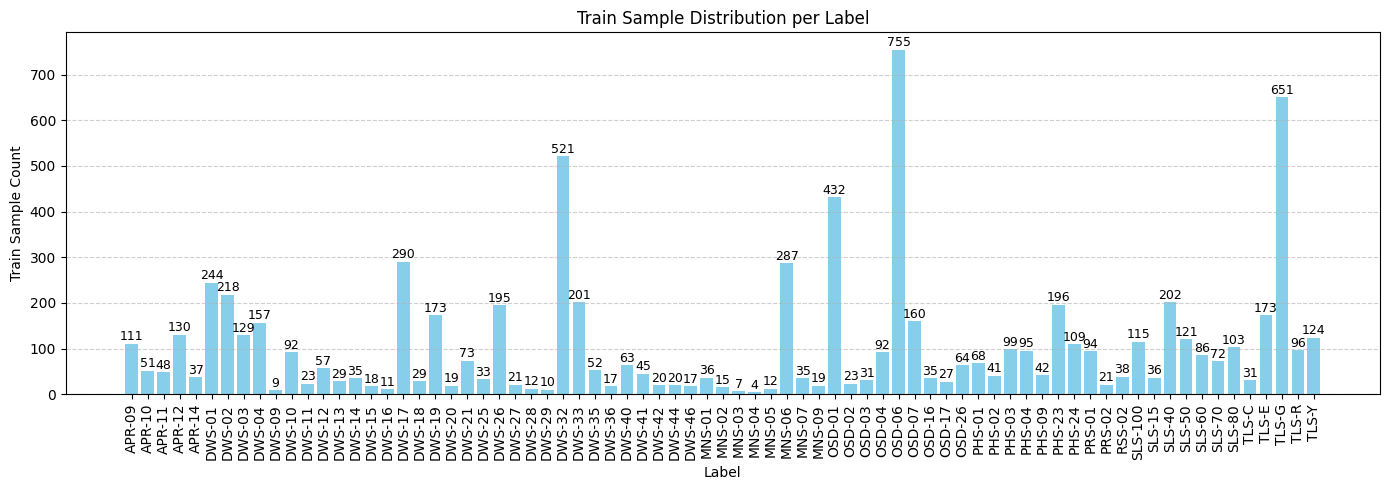

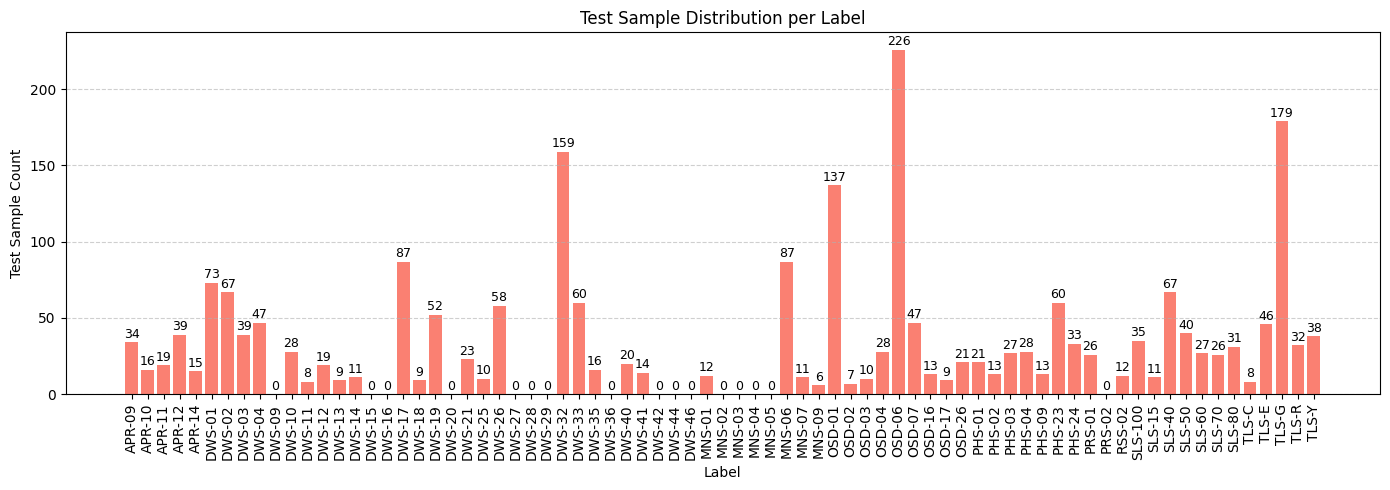

In [3]:
# Load and clean the data
df = pd.read_csv('/content/dataset/Main/label_frequencies.xlsx - Label Frequencies.csv')
df = df.drop(columns=['Total'])
df = df[df['Label'].str.lower() != 'total']

# --- Plot Train Distribution ---
plt.figure(figsize=(14, 5))
bars = plt.bar(df['Label'], df['Train'], color='skyblue')
plt.title('Train Sample Distribution per Label')
plt.xlabel('Label')
plt.ylabel('Train Sample Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# --- Plot Test Distribution ---
plt.figure(figsize=(14, 5))
bars = plt.bar(df['Label'], df['Test'], color='salmon')
plt.title('Test Sample Distribution per Label')
plt.xlabel('Label')
plt.ylabel('Test Sample Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [4]:
!ls /content/dataset/Main

'label_frequencies.xlsx - Label Frequencies.csv'   sample   test   train


In [5]:
import os
import shutil
import xml.etree.ElementTree as ET
import pandas as pd

# Define base dataset directory
base_dir = './dataset/Main'

# Create destination structure
splits = ['train', 'val', 'test']
for split in splits:
    os.makedirs(f'./final_dataset/{split}/images', exist_ok=True)
    os.makedirs(f'./final_dataset/{split}/labels', exist_ok=True)

# Read class labels from Excel
df = pd.read_csv('/content/dataset/Main/label_frequencies.xlsx - Label Frequencies.csv')
df = df.drop(columns=['Total'], errors='ignore')
df = df[df['Label'].str.lower() != 'total']
class_list = df['Label'].tolist()

# XML to YOLO format conversion
def convert_and_move(source_dir, img_files, target_split):
    for file in img_files:
        img_path = os.path.join(source_dir, file)
        xml_path = os.path.join(source_dir, file.replace('.jpg', '.xml'))

        if not os.path.exists(xml_path):
            continue

        # Copy image
        shutil.copy(img_path, f'./final_dataset/{target_split}/images/{file}')

        # Convert XML to YOLO
        tree = ET.parse(xml_path)
        root = tree.getroot()
        width = int(root.find("size/width").text)
        height = int(root.find("size/height").text)

        with open(f'./final_dataset/{target_split}/labels/{file.replace(".jpg", ".txt")}', "w") as f:
            for obj in root.findall("object"):
                class_name = obj.find("name").text
                if class_name not in class_list:
                    continue
                class_id = class_list.index(class_name)

                bbox = obj.find("bndbox")
                xmin = int(bbox.find("xmin").text)
                ymin = int(bbox.find("ymin").text)
                xmax = int(bbox.find("xmax").text)
                ymax = int(bbox.find("ymax").text)

                cx = ((xmin + xmax) / 2) / width
                cy = ((ymin + ymax) / 2) / height
                w = (xmax - xmin) / width
                h = (ymax - ymin) / height

                f.write(f"{class_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

# Process train set
train_dir = os.path.join(base_dir, 'train')
train_images = [f for f in os.listdir(train_dir) if f.endswith('.jpg')]
convert_and_move(train_dir, train_images, 'train')

# Split test into test and val (50/50)
test_dir = os.path.join(base_dir, 'test')
test_images = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]
mid = len(test_images) // 2
val_images = test_images[:mid]
test_images = test_images[mid:]

convert_and_move(test_dir, val_images, 'val')
convert_and_move(test_dir, test_images, 'test')

<Figure size 1600x600 with 0 Axes>

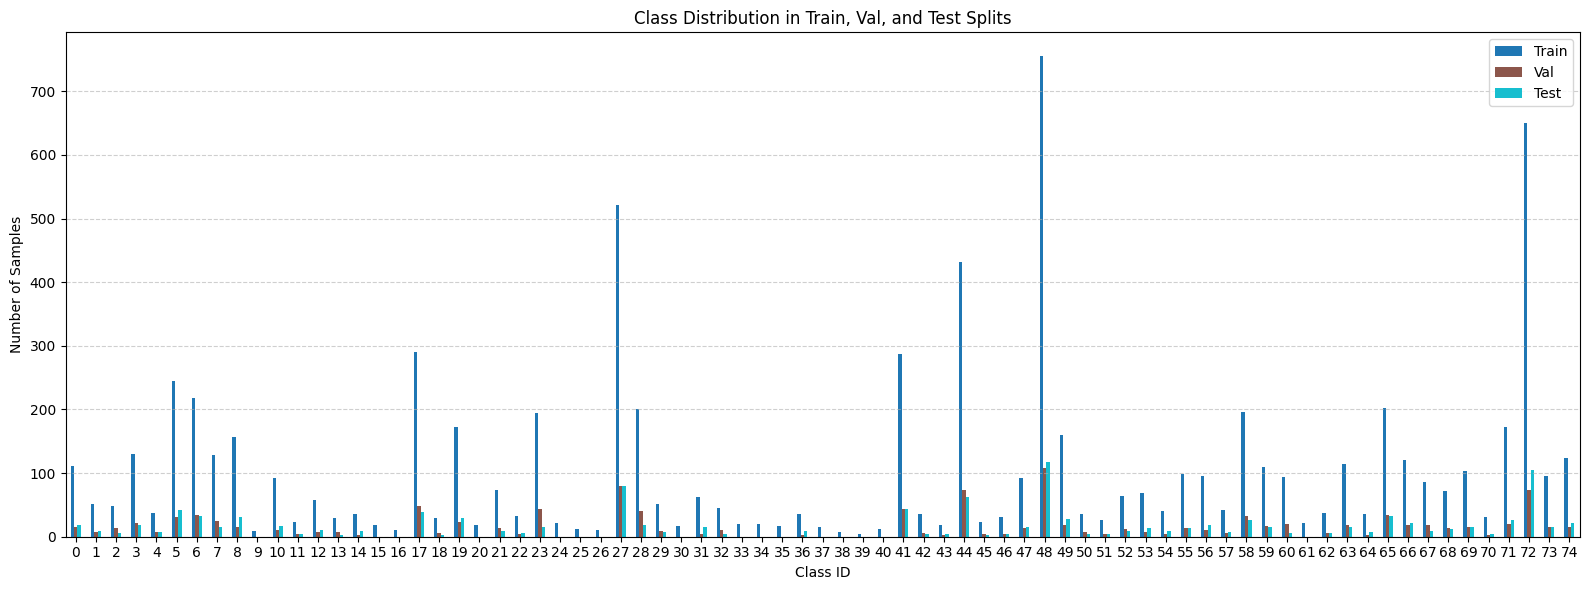

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Define label folder paths
label_dirs = {
    'Train': './final_dataset/train/labels',
    'Val': './final_dataset/val/labels',
    'Test': './final_dataset/test/labels'
}

# Count class occurrences for each split
split_counts = {}
for split_name, label_path in label_dirs.items():
    class_counter = Counter()
    for file in os.listdir(label_path):
        if file.endswith('.txt'):
            with open(os.path.join(label_path, file), 'r') as f:
                for line in f:
                    if line.strip():
                        try:
                            class_id = int(line.strip().split()[0])
                            class_counter[class_id] += 1
                        except ValueError:
                            continue
    split_counts[split_name] = class_counter

# Convert to DataFrame
df_dist = pd.DataFrame(split_counts).fillna(0).astype(int)
df_dist.index.name = 'Class ID'
df_dist = df_dist.sort_index()

# Plotting
plt.figure(figsize=(16, 6))
df_dist.plot(kind='bar', figsize=(16, 6), colormap='tab10')
plt.title('Class Distribution in Train, Val, and Test Splits')
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [7]:
import pandas as pd

# Load class names from your Excel file
df = pd.read_csv('/content/dataset/Main/label_frequencies.xlsx - Label Frequencies.csv')

# Drop "Total" column and row if present
df = df.drop(columns=['Total'], errors='ignore')
df = df[df['Label'].str.lower() != 'total']

# Generate the 'names' YAML section
print("names:")
for idx, name in enumerate(df['Label']):
    print(f"  {idx}: {name}")


names:
  0: APR-09
  1: APR-10
  2: APR-11
  3: APR-12
  4: APR-14
  5: DWS-01
  6: DWS-02
  7: DWS-03
  8: DWS-04
  9: DWS-09
  10: DWS-10
  11: DWS-11
  12: DWS-12
  13: DWS-13
  14: DWS-14
  15: DWS-15
  16: DWS-16
  17: DWS-17
  18: DWS-18
  19: DWS-19
  20: DWS-20
  21: DWS-21
  22: DWS-25
  23: DWS-26
  24: DWS-27
  25: DWS-28
  26: DWS-29
  27: DWS-32
  28: DWS-33
  29: DWS-35
  30: DWS-36
  31: DWS-40
  32: DWS-41
  33: DWS-42
  34: DWS-44
  35: DWS-46
  36: MNS-01
  37: MNS-02
  38: MNS-03
  39: MNS-04
  40: MNS-05
  41: MNS-06
  42: MNS-07
  43: MNS-09
  44: OSD-01
  45: OSD-02
  46: OSD-03
  47: OSD-04
  48: OSD-06
  49: OSD-07
  50: OSD-16
  51: OSD-17
  52: OSD-26
  53: PHS-01
  54: PHS-02
  55: PHS-03
  56: PHS-04
  57: PHS-09
  58: PHS-23
  59: PHS-24
  60: PRS-01
  61: PRS-02
  62: RSS-02
  63: SLS-100
  64: SLS-15
  65: SLS-40
  66: SLS-50
  67: SLS-60
  68: SLS-70
  69: SLS-80
  70: TLS-C
  71: TLS-E
  72: TLS-G
  73: TLS-R
  74: TLS-Y


In [8]:
!pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu113
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Un

In [9]:
import torch
import torch.nn as nn
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [10]:
import torch
import torch.nn as nn
from ultralytics import YOLO

# Load the pre-trained YOLOv8 model
model = YOLO('yolo12n.pt')  # You can choose other variants like yolov8s.pt, yolov8m.pt, etc.

100%|██████████| 5.34M/5.34M [00:00<00:00, 100MB/s]


In [11]:
from ultralytics import YOLO

# Load the YOLOv12n model (pretrained)
model = YOLO('yolo12n.pt')

# Train the model
model.train(
    data='/content/final_dataset/data.yaml',
    epochs=200,                    # number of epochs
    patience=15,
    imgsz=640,                      # input image size
    batch=64,                       # experiment name
    verbose=True                   # show training logs
)

Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/final_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspective=0.0, plots=True, pose=12.0, pretr

100%|██████████| 755k/755k [00:00<00:00, 21.1MB/s]

Overriding model.yaml nc=80 with nc=75

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    180864  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralytic

 21        [14, 17, 20]  1    457782  ultralytics.nn.modules.head.Detect           [75, [64, 128, 256]]          
YOLOv12n summary: 272 layers, 2,595,158 parameters, 2,595,142 gradients, 6.6 GFLOPs

Transferred 640/691 items from pretrained weights
Freezing layer 'model.21.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 103MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3066.1±2068.6 MB/s, size: 650.3 KB)


train: Scanning /content/final_dataset/train/labels... 6143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6143/6143 [00:03<00:00, 1558.72it/s]


train: New cache created: /content/final_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2906.8±1690.0 MB/s, size: 586.1 KB)


val: Scanning /content/final_dataset/val/labels... 920 images, 0 backgrounds, 0 corrupt: 100%|██████████| 920/920 [00:00<00:00, 1143.83it/s]

val: New cache created: /content/final_dataset/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      12.8G      1.375       5.94     0.9689        142        640: 100%|██████████| 96/96 [01:12<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]


                   all        920       1155     0.0543     0.0789     0.0469     0.0326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      12.9G      1.362      4.479     0.9599        129        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


                   all        920       1155      0.472      0.209      0.114     0.0793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      12.9G      1.411      4.004     0.9883        149        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


                   all        920       1155       0.33      0.236      0.107     0.0766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      12.9G       1.36      3.493     0.9883        152        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


                   all        920       1155      0.346      0.271      0.167      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      12.9G      1.277      2.792     0.9733        133        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


                   all        920       1155      0.468      0.341      0.265      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      12.9G      1.198      2.316     0.9513        138        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


                   all        920       1155      0.407      0.366      0.299      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      12.9G      1.174      2.025     0.9431        137        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


                   all        920       1155      0.395      0.352      0.295      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      12.9G       1.14      1.853     0.9347        136        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


                   all        920       1155      0.491      0.381      0.349      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      12.9G      1.135      1.773     0.9329        164        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


                   all        920       1155      0.433      0.456      0.382      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      12.9G      1.104      1.672     0.9298        125        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155       0.56      0.411      0.404      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      12.9G      1.089      1.612     0.9215        136        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


                   all        920       1155      0.528      0.447      0.422      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      12.9G      1.053      1.519     0.9159        128        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


                   all        920       1155        0.5      0.477      0.451      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      12.9G      1.064      1.506     0.9129        168        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


                   all        920       1155      0.496      0.445       0.42      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      12.9G      1.048      1.436     0.9128        134        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]

                   all        920       1155      0.602      0.436      0.435      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200        13G      1.036      1.387     0.9087        145        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


                   all        920       1155      0.608      0.483      0.495      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      12.9G      1.027       1.35      0.907        147        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


                   all        920       1155      0.517      0.504      0.498      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      12.9G      1.039      1.351     0.9058        148        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


                   all        920       1155      0.606      0.477      0.484      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      12.9G      1.019       1.32     0.9079        155        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


                   all        920       1155      0.591      0.491      0.504      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      12.9G      1.021      1.304     0.9069        115        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


                   all        920       1155      0.469      0.519      0.484      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      12.9G      1.016       1.29     0.8993        155        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]


                   all        920       1155       0.66      0.503      0.521      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      12.9G     0.9879      1.224     0.8939        140        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


                   all        920       1155      0.588      0.479      0.474      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      12.9G      0.981       1.21     0.8931        133        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


                   all        920       1155      0.587      0.564      0.546      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      12.9G     0.9846      1.194      0.891        147        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


                   all        920       1155      0.651      0.535      0.573      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      12.9G      0.981      1.164     0.8893        152        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.591      0.532      0.562      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200        13G     0.9667      1.145     0.8922        131        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        920       1155      0.598      0.497       0.54      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      12.9G     0.9692      1.149     0.8887        125        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.644      0.502       0.57      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      12.9G     0.9718      1.153      0.891        150        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155       0.58      0.553      0.575       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      12.9G     0.9629      1.109     0.8903        132        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.663      0.546      0.596      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      12.9G     0.9568      1.099      0.886        145        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


                   all        920       1155      0.667      0.517      0.576      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      12.9G     0.9501      1.086     0.8859        139        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.702      0.531      0.605      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      12.9G     0.9428       1.07     0.8828        152        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


                   all        920       1155      0.644      0.535      0.584      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      12.9G     0.9591       1.08      0.883        130        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


                   all        920       1155      0.725       0.55      0.618      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      12.9G     0.9588      1.091     0.8829        164        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


                   all        920       1155      0.635      0.569      0.609       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      12.9G     0.9456      1.057     0.8821        112        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


                   all        920       1155      0.703      0.548      0.609      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      12.9G     0.9242      1.023     0.8764        123        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.689      0.544      0.621      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      12.9G     0.9225      1.011     0.8747        159        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


                   all        920       1155      0.728      0.503      0.594      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      12.9G     0.9236      1.017     0.8756        136        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.742       0.53      0.637      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      12.9G     0.9279     0.9948     0.8798        151        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        920       1155      0.678      0.579      0.645      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      12.9G     0.9382      1.003     0.8812        115        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.742      0.567      0.667      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      12.9G     0.9182     0.9656     0.8774        142        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


                   all        920       1155      0.688      0.559      0.627      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      12.9G      0.905     0.9771     0.8715        125        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155       0.71      0.575      0.667      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      12.9G     0.9299     0.9753     0.8789        114        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.816      0.552      0.668      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      12.9G      0.913      0.949     0.8754        129        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.689      0.624      0.681      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      12.9G     0.9052      0.947     0.8717        123        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.715      0.615      0.677      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      12.9G     0.9056     0.9425     0.8705        142        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155       0.65      0.606      0.662      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      12.9G     0.9041     0.9364     0.8755        147        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.754      0.581      0.682      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      12.9G     0.9051     0.9323     0.8698        138        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.00it/s]

                   all        920       1155      0.658      0.626      0.672      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      12.9G     0.8926     0.9087     0.8693        183        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.813      0.596      0.705      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      12.9G     0.9022      0.921     0.8678        153        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]

                   all        920       1155      0.704      0.645      0.706      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      12.9G     0.8866     0.8988     0.8676        142        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.764       0.57      0.681      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      12.9G     0.8745     0.8859     0.8658        145        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


                   all        920       1155      0.722      0.641      0.699      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      12.9G     0.8852     0.8874     0.8673        134        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


                   all        920       1155      0.746      0.638      0.714       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      12.9G     0.8943     0.8867      0.869        143        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


                   all        920       1155      0.765      0.633      0.703      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      12.9G      0.877     0.8783     0.8629        133        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        920       1155      0.751      0.647      0.724      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      12.9G     0.8827      0.865     0.8671        135        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]

                   all        920       1155      0.768      0.628      0.714      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      12.9G      0.878     0.8633     0.8637        121        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


                   all        920       1155      0.685      0.683      0.737      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200        13G     0.8657     0.8539     0.8608        162        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


                   all        920       1155      0.743      0.638      0.721      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      12.9G     0.8807     0.8703     0.8668        139        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.749      0.641      0.722      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      12.9G     0.8875     0.8528     0.8657        128        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.769      0.645      0.733      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      12.9G     0.8687      0.844     0.8618        133        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155       0.79      0.663       0.75      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      12.9G     0.8538      0.814     0.8639        175        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


                   all        920       1155      0.769       0.67      0.738      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      12.9G     0.8657     0.8297     0.8634        158        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.769      0.665       0.74      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      12.9G     0.8702     0.8308     0.8612        132        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.785      0.669      0.758      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      12.9G     0.8592     0.8173     0.8627        133        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.806      0.656      0.747      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      12.9G     0.8522     0.8154     0.8594        145        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]

                   all        920       1155      0.839      0.648      0.775       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      12.9G     0.8587     0.8123     0.8599        144        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.807      0.661      0.759      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      12.9G     0.8493     0.7972     0.8572        145        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]

                   all        920       1155      0.815      0.668      0.764      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      12.9G     0.8606     0.8082     0.8578        118        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.793      0.669       0.76      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      12.9G     0.8617     0.7956     0.8618        146        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.845      0.654      0.756      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      12.9G       0.85     0.7832     0.8577        140        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.764      0.712       0.77      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      12.9G     0.8341     0.7739      0.856        159        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155       0.75      0.693      0.751      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      12.9G     0.8407     0.7741     0.8576        153        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.814      0.659      0.759      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      12.9G     0.8364      0.775     0.8561        113        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155       0.77      0.696      0.769      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      12.9G     0.8326     0.7622     0.8562        144        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


                   all        920       1155      0.901      0.637      0.773      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      12.9G     0.8457      0.782     0.8559        150        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.768      0.725      0.776      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      12.9G     0.8403     0.7648     0.8586        139        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]

                   all        920       1155       0.85      0.706      0.785       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      12.9G     0.8307     0.7599     0.8543        140        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.805      0.702      0.793      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      12.9G     0.8275     0.7295     0.8514        118        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]

                   all        920       1155      0.771      0.743      0.795      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      12.9G     0.8366     0.7648     0.8571        121        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.795      0.714      0.789      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      12.9G      0.825     0.7549     0.8557        134        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.805      0.706      0.796      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      12.9G     0.8259     0.7351     0.8531        150        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.821      0.724      0.791      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      12.9G     0.8196     0.7193     0.8519        152        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.817      0.724      0.796      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      12.9G     0.8245     0.7247     0.8501        148        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155       0.81      0.709      0.795      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      12.9G     0.8151     0.7163     0.8534        141        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155       0.79      0.749      0.811      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      12.9G     0.8266     0.7313     0.8497        151        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.802       0.74      0.813      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      12.9G     0.8078     0.7074      0.852        139        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


                   all        920       1155      0.799      0.733      0.811      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200        13G     0.8191     0.7233     0.8532        133        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]

                   all        920       1155      0.806      0.727      0.809      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      12.9G     0.8083      0.718     0.8508        120        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]

                   all        920       1155      0.819      0.723      0.807      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      12.9G     0.8039     0.6983     0.8483        151        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]

                   all        920       1155      0.796      0.739      0.804      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      12.9G     0.8135     0.7102     0.8514        135        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.813       0.74      0.802      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      12.9G     0.8016     0.6983     0.8476        143        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.798      0.729      0.809      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      12.9G     0.8029     0.6968      0.847        146        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.796       0.75      0.808       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      12.9G     0.8094     0.6939      0.849        145        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.817      0.763       0.81      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      12.9G     0.8052      0.691     0.8512        169        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.851      0.741       0.81      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      12.9G     0.8023     0.6798     0.8448        159        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]

                   all        920       1155      0.854      0.749      0.815      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200        13G     0.8047     0.6907     0.8488        163        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.865      0.735      0.815      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      12.9G     0.8006     0.6903     0.8492        130        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]

                   all        920       1155       0.84      0.748      0.816      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      12.9G     0.7967     0.6694     0.8452        156        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]

                   all        920       1155      0.839      0.741      0.811      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      12.9G     0.7883     0.6641     0.8435        144        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


                   all        920       1155      0.858      0.741      0.812      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      12.9G     0.7822     0.6621     0.8445        119        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]

                   all        920       1155       0.84      0.746      0.818      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      12.9G     0.7948     0.6567     0.8446        131        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.828      0.752      0.816      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      12.9G     0.7755     0.6468     0.8411        139        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]

                   all        920       1155      0.838      0.755      0.812      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      12.9G      0.776     0.6459     0.8445        140        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.789      0.764      0.817      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      12.9G      0.785     0.6481     0.8438        167        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.811      0.766      0.822      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      12.9G     0.7844     0.6607     0.8461        125        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.794      0.772      0.825      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      12.9G     0.7755     0.6359     0.8435        136        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155       0.83      0.756      0.825      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      12.9G     0.7845     0.6643      0.844        126        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.833      0.751      0.826      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      12.9G     0.7803     0.6523     0.8406        157        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155       0.83      0.747      0.829      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      12.9G     0.7772     0.6363     0.8422        149        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.811      0.748      0.829      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      12.9G     0.7678      0.633     0.8433        142        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        920       1155      0.851      0.741      0.831      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      12.9G     0.7637     0.6293     0.8399        132        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.805      0.766      0.831      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      12.9G     0.7652     0.6276     0.8396        133        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.829      0.769      0.833      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200        13G     0.7643     0.6257     0.8415        135        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


                   all        920       1155      0.826      0.769      0.833      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      12.9G     0.7584     0.6205     0.8398        131        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


                   all        920       1155      0.866      0.741      0.833      0.687

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      12.9G     0.7598     0.6193     0.8387        138        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


                   all        920       1155      0.879       0.74      0.829      0.678

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      12.9G     0.7628     0.6261     0.8402        150        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]

                   all        920       1155      0.788      0.769      0.831      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      12.9G     0.7642     0.6152     0.8403        116        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]

                   all        920       1155      0.837       0.75       0.83      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      12.9G     0.7496     0.6096     0.8382        144        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        920       1155       0.86      0.743      0.832       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      12.9G     0.7524     0.6105      0.838        139        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.90it/s]

                   all        920       1155      0.866      0.744      0.828       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      12.9G      0.758     0.6014     0.8405        142        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]

                   all        920       1155      0.854      0.742      0.828      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      12.9G     0.7451     0.5954     0.8388        132        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.834      0.744       0.83      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      12.9G     0.7432     0.6046     0.8373        134        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.818       0.76      0.832      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      12.9G     0.7426       0.59     0.8387        140        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.831       0.76      0.832      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      12.9G     0.7529      0.594     0.8386        143        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]

                   all        920       1155      0.829      0.764      0.834      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      12.9G     0.7485     0.6061     0.8392        144        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.837       0.76      0.833      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      12.9G     0.7426     0.6002      0.836        113        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.829      0.771      0.834      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      12.9G     0.7376     0.5753     0.8376        194        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.848      0.755      0.833      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      12.9G     0.7286     0.5856     0.8345        133        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.855      0.752      0.834      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      12.9G     0.7358     0.5809     0.8361        152        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.889      0.742      0.834      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      12.9G      0.724     0.5751     0.8371        132        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155       0.89      0.744      0.836      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      12.9G     0.7446     0.5901     0.8354        128        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.885      0.747      0.837      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      12.9G     0.7245     0.5765     0.8359        140        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155       0.87       0.76      0.837      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      12.9G     0.7285     0.5688     0.8312        152        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.877      0.761      0.842      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200        13G     0.7366     0.5763     0.8336        147        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.872      0.773      0.841      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      12.9G     0.7263     0.5684     0.8327        137        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]

                   all        920       1155      0.876      0.763      0.838      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      12.9G     0.7332     0.5717     0.8367        155        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155       0.87      0.767      0.837      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      12.9G     0.7297     0.5747     0.8315        156        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.871      0.772      0.841      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      12.9G     0.7189      0.558     0.8322        134        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]

                   all        920       1155      0.862      0.771      0.836      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      12.9G     0.7184     0.5498     0.8351        160        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.875       0.76      0.838      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      12.9G     0.7221     0.5573     0.8353        129        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.00it/s]

                   all        920       1155      0.879      0.756      0.839      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      12.9G     0.7204     0.5569     0.8333        118        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.859      0.775       0.84      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      12.9G     0.7177     0.5466     0.8305        142        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.847       0.78      0.842      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      12.9G     0.7102     0.5432     0.8316        136        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.859      0.781      0.841      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      12.9G     0.7058     0.5414     0.8305        160        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.864       0.78      0.844      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      12.9G     0.7022     0.5314     0.8281        143        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.868       0.77      0.847      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      12.9G     0.7005     0.5383     0.8327        113        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.853      0.782      0.846      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      12.9G     0.7034     0.5332     0.8272        141        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.854      0.781      0.845      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      12.9G     0.7012     0.5383     0.8293        171        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.867      0.778      0.846        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      12.9G     0.7007     0.5281     0.8291        130        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.861      0.777      0.846      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      12.9G     0.7013     0.5321     0.8279        124        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]

                   all        920       1155      0.855      0.784      0.845      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      12.9G     0.6993     0.5329     0.8288        121        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.856      0.794      0.845      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      12.9G     0.6969     0.5311     0.8262        129        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155       0.86      0.783      0.845      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      12.9G     0.6998     0.5303     0.8297        129        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


                   all        920       1155      0.855      0.794      0.845      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      12.9G     0.6972       0.53      0.827        140        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.854      0.794      0.844      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      12.9G     0.6919      0.519     0.8281        127        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.855      0.798      0.845      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      12.9G     0.6995     0.5204     0.8288        122        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.854      0.795      0.847      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      12.9G     0.6879     0.5152      0.826        120        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


                   all        920       1155      0.854      0.794      0.847      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      12.9G      0.694     0.5151      0.829        181        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]

                   all        920       1155      0.855      0.791      0.846      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      12.9G     0.6887     0.5136     0.8251        125        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.88it/s]

                   all        920       1155      0.857       0.79      0.847      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      12.9G      0.691     0.5175     0.8292        131        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.90it/s]

                   all        920       1155      0.858       0.79      0.847      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      12.9G       0.68     0.5122     0.8252        154        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]

                   all        920       1155       0.86      0.786      0.847      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      12.9G     0.6845     0.5022     0.8239        154        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.866      0.785      0.847      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      12.9G     0.6761     0.4984     0.8233        165        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]

                   all        920       1155      0.862      0.791      0.848      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      12.9G     0.6805     0.5089     0.8223        135        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.864      0.791      0.849      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      12.9G     0.6717     0.4936     0.8241        152        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155       0.87      0.782      0.848      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      12.9G     0.6806     0.4996     0.8246        154        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]

                   all        920       1155       0.87      0.782      0.847      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      12.9G      0.678     0.5014     0.8272        138        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.869      0.783      0.848      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      12.9G     0.6752     0.4994     0.8257        108        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.868      0.784      0.849      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      12.9G      0.663     0.4888     0.8235        135        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.00it/s]

                   all        920       1155      0.868      0.785       0.85      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      12.9G     0.6676     0.4924     0.8226        146        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.869      0.785       0.85      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      12.9G     0.6679     0.4819     0.8235        151        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.868      0.787       0.85      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200        13G     0.6645     0.4854     0.8241        147        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.867      0.788      0.851      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      12.9G     0.6579     0.4725     0.8201        146        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.865      0.787      0.852      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      12.9G     0.6567     0.4842     0.8236        135        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]

                   all        920       1155      0.866      0.787      0.852      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      12.9G      0.653     0.4738     0.8179        136        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.871      0.784      0.851      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      12.9G     0.6534     0.4744     0.8202        170        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.858      0.791      0.851      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      12.9G     0.6597     0.4784     0.8228        154        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.849      0.795      0.853      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      12.9G     0.6498     0.4731     0.8181        150        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.831       0.81      0.853      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      12.9G     0.6524     0.4704     0.8199        127        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.832       0.81      0.853      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      12.9G     0.6452     0.4704     0.8195        156        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.833      0.809      0.853      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      12.9G      0.645     0.4645     0.8225        164        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.839      0.806      0.854      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      12.9G     0.6528     0.4683     0.8224        142        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.837      0.807      0.854      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      12.9G     0.6446      0.462     0.8197        150        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.832      0.812      0.854      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      12.9G     0.6425     0.4559     0.8179        157        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.841      0.804      0.854      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200        13G     0.6366     0.4575     0.8194        136        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.836      0.811      0.855      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      12.9G     0.6345     0.4531     0.8158        127        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.835      0.812      0.855      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      12.9G     0.6252     0.4508     0.8164        136        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.835      0.813      0.855      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      12.9G      0.633     0.4549     0.8187        132        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.835      0.814      0.855      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      12.9G     0.6299     0.4478      0.817        130        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.835      0.813      0.855      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200        13G     0.6273     0.4468     0.8146        149        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]

                   all        920       1155      0.835      0.813      0.855      0.709


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      12.8G     0.6317     0.4455     0.8224         80        640: 100%|██████████| 96/96 [01:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.834      0.814      0.854      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      12.8G     0.6193     0.4218     0.8212         79        640: 100%|██████████| 96/96 [01:05<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.836      0.812      0.854      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      12.8G     0.6142      0.419     0.8196         76        640: 100%|██████████| 96/96 [01:05<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.835      0.813      0.854      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      12.8G     0.6041     0.4092     0.8176         69        640: 100%|██████████| 96/96 [01:05<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.835      0.814      0.854      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      12.8G      0.596     0.4001     0.8147         62        640: 100%|██████████| 96/96 [01:05<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.835      0.814      0.854      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      12.9G      0.605     0.4084     0.8172         69        640: 100%|██████████| 96/96 [01:05<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.836      0.815      0.855      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      12.9G     0.5956     0.3987     0.8123         76        640: 100%|██████████| 96/96 [01:05<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]

                   all        920       1155      0.839      0.814      0.857       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      12.8G     0.5938     0.3935      0.813         63        640: 100%|██████████| 96/96 [01:05<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.842      0.814      0.858       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      12.9G      0.591     0.3932     0.8171         73        640: 100%|██████████| 96/96 [01:05<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.844      0.811      0.858      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      12.9G     0.5897     0.3957     0.8128         70        640: 100%|██████████| 96/96 [01:05<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.843      0.814      0.859      0.711



200 epochs completed in 3.945 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv12n summary (fused): 159 layers, 2,583,739 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


                   all        920       1155      0.845       0.81      0.858      0.711
                APR-09         15         15      0.724        0.8      0.794      0.583
                APR-10          7          7      0.852      0.825      0.924      0.772
                APR-11         13         13      0.958      0.923      0.986      0.755
                APR-12         21         21      0.848       0.81      0.928      0.718
                APR-14          8          8      0.817      0.875      0.866      0.717
                DWS-01         31         31       0.95          1      0.982      0.925
                DWS-02         34         34      0.976          1      0.995      0.944
                DWS-03         24         24      0.999          1      0.995      0.926
                DWS-04         16         16      0.864          1      0.991      0.907
                DWS-10         11         11          1       0.99      0.995       0.85
                DWS-1

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 17, 18, 19, 21, 22, 23, 27, 28, 29, 31, 32, 36, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b43a17ec610>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031

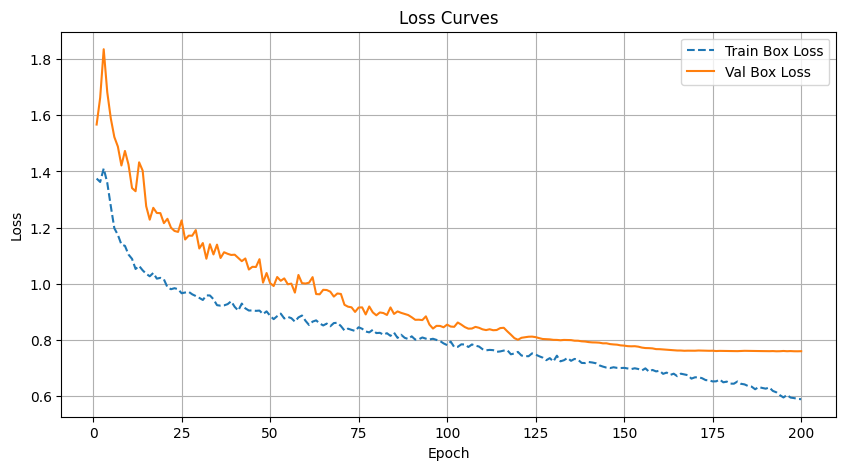

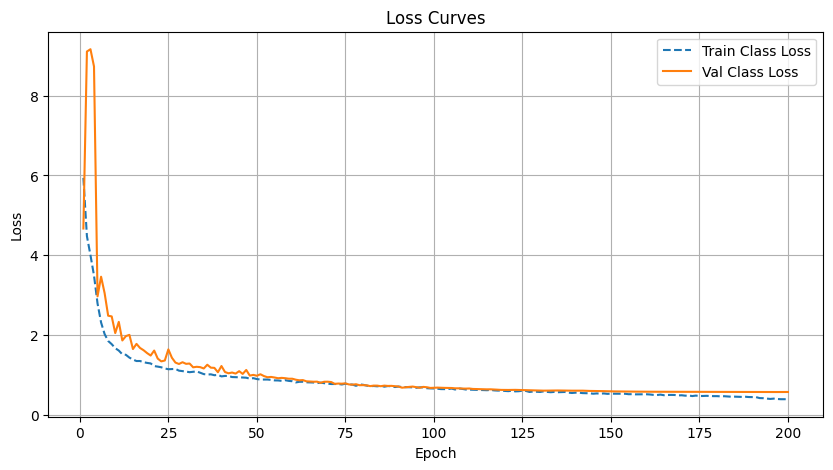

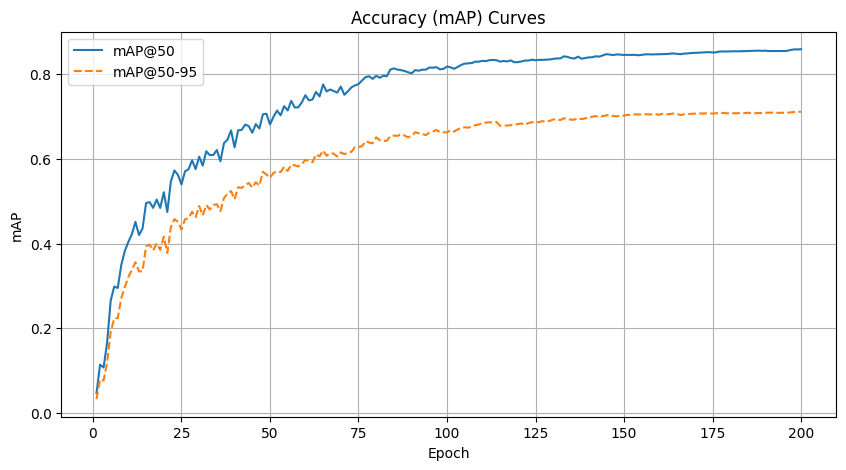

In [18]:
# Load the CSV file
results_path = "/content/runs/detect/train/results.csv"  # Update path if needed
df = pd.read_csv(results_path)

# Remove extra spaces from column names
df.columns = df.columns.str.strip()

# Now, plot the curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', linestyle='dashed')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.show()

print("     ")
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss', linestyle='dashed')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.show()

print("     ")
# Plot mAP Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Accuracy (mAP) Curves')
plt.legend()
plt.grid()
plt.show()

In [13]:
results = model.val()
print(results)

Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv12n summary (fused): 159 layers, 2,583,739 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4831.0±1040.2 MB/s, size: 714.2 KB)


val: Scanning /content/final_dataset/val/labels.cache... 920 images, 0 backgrounds, 0 corrupt: 100%|██████████| 920/920 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  1.94it/s]


                   all        920       1155      0.845       0.81      0.858      0.712
                APR-09         15         15      0.726        0.8      0.794      0.597
                APR-10          7          7      0.852      0.825      0.924      0.772
                APR-11         13         13      0.959      0.923       0.99      0.769
                APR-12         21         21      0.848       0.81      0.927      0.717
                APR-14          8          8      0.823      0.875      0.866      0.717
                DWS-01         31         31       0.95          1      0.982      0.932
                DWS-02         34         34      0.976          1      0.995       0.94
                DWS-03         24         24      0.999          1      0.995      0.926
                DWS-04         16         16      0.864          1      0.991      0.908
                DWS-10         11         11          1       0.99      0.995       0.85
                DWS-1

In [14]:
from thop import profile
from ultralytics import YOLO
import torch

# ✅ Load model properly
model = YOLO('/content/runs/detect/train/weights/best.pt')
torch_model = model.model  # Raw nn.Module

# ✅ Create dummy input
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_tensor = torch.randn(1, 3, 640, 640).to(device)

# ✅ Move model to same device
torch_model = torch_model.to(device)

# ✅ Profile
macs, params = profile(torch_model, inputs=(input_tensor,), verbose=False)

# ✅ Print results
print(f"Params: {params / 1e6:.2f} Million")
print(f"MACs: {macs / 1e9:.2f} GMACs")
print(f"FLOPs: {2 * macs / 1e9:.2f} GFLOPs (approx)")

Params: 2.60 Million
MACs: 3.31 GMACs
FLOPs: 6.62 GFLOPs (approx)


In [15]:
from ultralytics import YOLO

# Load your trained YOLOv8n model
model = YOLO('/content/runs/detect/train/weights/best.pt')  # change path if needed

# Evaluate on validation set
metrics = model.val()

Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv12n summary (fused): 159 layers, 2,583,739 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4725.1±999.1 MB/s, size: 641.5 KB)


val: Scanning /content/final_dataset/val/labels.cache... 920 images, 0 backgrounds, 0 corrupt: 100%|██████████| 920/920 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.61it/s]


                   all        920       1155      0.845       0.81      0.858      0.712
                APR-09         15         15      0.725        0.8      0.794      0.597
                APR-10          7          7      0.852      0.825      0.924      0.772
                APR-11         13         13      0.959      0.923       0.99      0.769
                APR-12         21         21      0.848       0.81      0.927      0.717
                APR-14          8          8      0.823      0.875      0.866      0.717
                DWS-01         31         31       0.95          1      0.982      0.932
                DWS-02         34         34      0.976          1      0.995       0.94
                DWS-03         24         24      0.999          1      0.995      0.926
                DWS-04         16         16      0.864          1      0.991      0.908
                DWS-10         11         11          1       0.99      0.995       0.85
                DWS-1

In [16]:
# Extract metrics from `metrics.box`
precision = metrics.box.p.mean()       # mean precision
recall = metrics.box.r.mean()          # mean recall
map50 = metrics.box.ap50.mean()        # mAP@0.5
map5095 = metrics.box.ap.mean()        # mAP@0.5:0.95

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

# Print summary
print("\n✅ 📊 Overall Evaluation Summary:")
print(f"{'Metric':<15} | {'Value':>8}")
print(f"{'-'*26}")
print(f"{'mAP@50':<15} | {map50:.3f}")
print(f"{'mAP@50-95':<15} | {map5095:.3f}")
print(f"{'Precision':<15} | {precision:.3f}")
print(f"{'Recall':<15} | {recall:.3f}")
print(f"{'F1-Score':<15} | {f1_score:.3f}")


✅ 📊 Overall Evaluation Summary:
Metric          |    Value
--------------------------
mAP@50          | 0.858
mAP@50-95       | 0.712
Precision       | 0.845
Recall          | 0.810
F1-Score        | 0.827


In [ ]:
from ultralytics import YOLO

# Load the YOLOv12n model (pretrained)
model = YOLO('yolo12n.pt')

# Train the model
model.train(
    data='/content/final_dataset/data.yaml',
    epochs=200,                    # number of epochs
    patience=15,
    imgsz=640,                      # input image size
    batch=64,
    optimizer='AdamW',
    lr0=0.000127,# experiment name
    verbose=True                   # show training logs
)

Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/final_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.000127, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=15, perspective=0.0, plots=True, pose=12.0,

train: Scanning /content/final_dataset/train/labels.cache... 6143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6143/6143 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1797.0±1480.2 MB/s, size: 586.1 KB)


val: Scanning /content/final_dataset/val/labels.cache... 920 images, 0 backgrounds, 0 corrupt: 100%|██████████| 920/920 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: AdamW(lr=0.000127, momentum=0.937) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train3
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      13.2G      1.407      4.849     0.9794        142        640: 100%|██████████| 96/96 [01:08<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.03it/s]

                   all        920       1155          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      12.9G      1.293      3.514     0.9517        129        640: 100%|██████████| 96/96 [01:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.473     0.0749      0.065     0.0485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      12.9G      1.246      2.963     0.9418        149        640: 100%|██████████| 96/96 [01:07<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


                   all        920       1155      0.488      0.174       0.15      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      12.9G      1.163      2.567      0.922        152        640: 100%|██████████| 96/96 [01:08<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.419      0.246      0.208      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      12.9G      1.131      2.329     0.9162        133        640: 100%|██████████| 96/96 [01:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


                   all        920       1155      0.356      0.331      0.257      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      12.9G      1.091      2.131     0.9044        138        640: 100%|██████████| 96/96 [01:08<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.494      0.297       0.28      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      12.9G      1.064      1.997      0.899        137        640: 100%|██████████| 96/96 [01:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.473      0.349      0.329      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      12.9G      1.041      1.872     0.8938        136        640: 100%|██████████| 96/96 [01:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]

                   all        920       1155      0.528      0.393       0.36      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      12.9G      1.027      1.806     0.8939        164        640: 100%|██████████| 96/96 [01:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.505      0.405      0.391      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200        13G      1.018      1.691      0.893        125        640: 100%|██████████| 96/96 [01:09<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


                   all        920       1155      0.515      0.433      0.424      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200        13G       1.01      1.632     0.8894        136        640: 100%|██████████| 96/96 [01:12<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


                   all        920       1155      0.459      0.479      0.447       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200        13G      0.974      1.519     0.8832        128        640: 100%|██████████| 96/96 [01:10<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.589      0.471      0.453      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200        13G     0.9816      1.486     0.8797        168        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.583      0.477      0.484      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      12.9G     0.9658      1.409     0.8827        134        640: 100%|██████████| 96/96 [01:10<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        920       1155      0.683      0.466        0.5      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200        13G     0.9503       1.34     0.8785        145        640: 100%|██████████| 96/96 [01:12<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.654      0.499      0.502      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      12.9G     0.9391      1.308     0.8761        147        640: 100%|██████████| 96/96 [01:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.705      0.493      0.532      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      12.9G     0.9632      1.286     0.8752        148        640: 100%|██████████| 96/96 [01:10<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


                   all        920       1155      0.711      0.507      0.546      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200        13G     0.9371      1.235     0.8773        155        640: 100%|██████████| 96/96 [01:12<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


                   all        920       1155      0.669      0.516      0.546      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      12.9G     0.9413      1.196     0.8749        115        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.55s/it]

                   all        920       1155      0.687      0.474      0.536      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      12.9G     0.9332      1.188     0.8708        155        640: 100%|██████████| 96/96 [01:10<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.703      0.524      0.572      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      12.9G     0.9095      1.115     0.8674        140        640: 100%|██████████| 96/96 [01:17<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:11<00:00,  1.44s/it]


                   all        920       1155      0.765      0.488      0.573      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      12.9G     0.9007      1.101     0.8646        133        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


                   all        920       1155      0.714      0.512      0.588      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      12.9G     0.9022      1.069     0.8641        147        640: 100%|██████████| 96/96 [01:12<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.15it/s]

                   all        920       1155      0.711      0.518      0.593      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      12.9G      0.904      1.038     0.8644        152        640: 100%|██████████| 96/96 [01:10<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.625      0.516      0.556      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200        13G     0.8885      1.026     0.8644        131        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.673      0.534       0.58      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      12.9G      0.891      1.025     0.8638        125        640: 100%|██████████| 96/96 [01:13<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


                   all        920       1155      0.721      0.536      0.614      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200        13G     0.8921      1.003     0.8661        150        640: 100%|██████████| 96/96 [01:10<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.694      0.558      0.612      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      12.9G     0.8868     0.9637     0.8661        132        640: 100%|██████████| 96/96 [01:15<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.717      0.571      0.621      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      12.9G     0.8821     0.9517     0.8619        145        640: 100%|██████████| 96/96 [01:11<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


                   all        920       1155      0.734      0.581      0.644      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      12.9G     0.8709     0.9302     0.8617        139        640: 100%|██████████| 96/96 [01:18<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


                   all        920       1155      0.735       0.58      0.637      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200        13G     0.8726      0.932     0.8618        152        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.766      0.576       0.64      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      12.9G     0.8707     0.9125     0.8583        130        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155       0.71       0.58      0.636       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      12.9G     0.8809     0.9155     0.8612        164        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.88it/s]

                   all        920       1155       0.79      0.577       0.66      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200        13G      0.859     0.8854     0.8584        112        640: 100%|██████████| 96/96 [01:11<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.759      0.564      0.648      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      12.9G     0.8401      0.845     0.8548        123        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.718      0.585      0.665      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      12.9G      0.844     0.8428     0.8531        159        640: 100%|██████████| 96/96 [01:11<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.54s/it]


                   all        920       1155      0.773      0.594      0.662       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200        13G     0.8446     0.8508     0.8539        136        640: 100%|██████████| 96/96 [01:18<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.52s/it]

                   all        920       1155       0.72      0.631       0.69      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      12.9G     0.8424     0.8311     0.8562        151        640: 100%|██████████| 96/96 [01:11<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.807      0.589      0.677       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      12.9G     0.8582     0.8417     0.8607        115        640: 100%|██████████| 96/96 [01:16<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


                   all        920       1155      0.778      0.583       0.67      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      12.9G     0.8333     0.8019      0.856        142        640: 100%|██████████| 96/96 [01:11<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155       0.76      0.605      0.672       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200        13G     0.8239     0.8085     0.8503        125        640: 100%|██████████| 96/96 [01:17<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]

                   all        920       1155      0.789      0.612      0.699      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      12.9G     0.8472     0.8163     0.8562        114        640: 100%|██████████| 96/96 [01:18<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.57s/it]


                   all        920       1155       0.81      0.602      0.693      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      12.9G     0.8218     0.7833     0.8535        129        640: 100%|██████████| 96/96 [01:12<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        920       1155      0.755      0.641      0.708      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      12.9G     0.8194     0.7707     0.8503        123        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:11<00:00,  1.50s/it]

                   all        920       1155      0.785      0.601      0.696      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      12.9G     0.8249      0.776     0.8493        142        640: 100%|██████████| 96/96 [01:12<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155       0.75      0.613      0.691       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      12.9G     0.8148     0.7637     0.8519        147        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:09<00:00,  1.24s/it]

                   all        920       1155      0.777      0.609      0.688      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      12.9G     0.8207     0.7554     0.8483        138        640: 100%|██████████| 96/96 [01:11<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.745      0.666      0.733      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      12.9G     0.8145     0.7549     0.8508        183        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.08s/it]

                   all        920       1155      0.765      0.668      0.721      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      12.9G     0.8139     0.7481     0.8477        153        640: 100%|██████████| 96/96 [01:17<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155       0.75      0.674      0.741      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      12.9G     0.8048      0.739     0.8483        142        640: 100%|██████████| 96/96 [01:12<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.741      0.655      0.718      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      12.9G     0.7912     0.7147     0.8462        145        640: 100%|██████████| 96/96 [01:18<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        920       1155      0.818      0.647      0.733      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      12.9G     0.8101     0.7285     0.8494        134        640: 100%|██████████| 96/96 [01:13<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.826       0.62       0.73      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      12.9G     0.8116     0.7215     0.8479        143        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.55s/it]


                   all        920       1155      0.849      0.651       0.74      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      12.9G      0.795     0.7074     0.8448        133        640: 100%|██████████| 96/96 [01:18<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]

                   all        920       1155      0.708      0.652      0.709      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      12.9G     0.7911     0.7088     0.8452        135        640: 100%|██████████| 96/96 [01:12<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.817      0.638      0.715      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      12.9G     0.7992     0.7039     0.8442        121        640: 100%|██████████| 96/96 [01:15<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.57s/it]


                   all        920       1155      0.851      0.669      0.757      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200        13G     0.7772     0.6935     0.8411        162        640: 100%|██████████| 96/96 [01:13<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.782      0.663      0.742      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      12.9G     0.7932     0.6971     0.8458        139        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.56s/it]


                   all        920       1155      0.767      0.673      0.745      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      12.9G     0.8011     0.6969     0.8474        128        640: 100%|██████████| 96/96 [01:15<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]

                   all        920       1155      0.782      0.679      0.741      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      12.9G     0.7912     0.6753     0.8448        133        640: 100%|██████████| 96/96 [01:12<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


                   all        920       1155      0.793      0.657      0.719      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200        13G     0.7696      0.663     0.8412        175        640: 100%|██████████| 96/96 [01:17<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:11<00:00,  1.48s/it]


                   all        920       1155       0.81      0.668      0.744      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      12.9G     0.7827     0.6823     0.8459        158        640: 100%|██████████| 96/96 [01:16<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.781      0.657      0.733      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200        13G     0.7887     0.6814     0.8431        132        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.823      0.664      0.753      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      12.9G     0.7682     0.6688     0.8401        133        640: 100%|██████████| 96/96 [01:16<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.53s/it]


                   all        920       1155      0.786      0.686      0.754      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      12.9G     0.7726      0.664     0.8433        145        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.88it/s]

                   all        920       1155      0.798      0.655      0.743      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      12.9G     0.7792      0.669     0.8422        144        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.773       0.68      0.754      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      12.9G     0.7688      0.656     0.8388        145        640: 100%|██████████| 96/96 [01:18<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:11<00:00,  1.50s/it]

                   all        920       1155      0.799      0.682      0.766      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      12.9G     0.7742     0.6627     0.8387        118        640: 100%|██████████| 96/96 [01:14<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.813      0.684      0.764      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      12.9G      0.781     0.6511     0.8427        146        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


                   all        920       1155      0.775      0.692      0.754      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      12.9G      0.768     0.6544     0.8396        140        640: 100%|██████████| 96/96 [01:17<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.789      0.705      0.772      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      12.9G      0.756     0.6259     0.8381        159        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.805       0.69      0.766      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      12.9G     0.7619      0.636      0.838        153        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.55s/it]

                   all        920       1155      0.846      0.698      0.767      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200        13G     0.7554     0.6285     0.8378        113        640: 100%|██████████| 96/96 [01:16<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        920       1155      0.819      0.689      0.766      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      12.9G     0.7485      0.625     0.8377        144        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.00it/s]

                   all        920       1155      0.826       0.67      0.751      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      12.9G     0.7659     0.6397     0.8381        150        640: 100%|██████████| 96/96 [01:16<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.55s/it]


                   all        920       1155      0.805      0.707      0.783      0.621

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200        13G     0.7599     0.6321     0.8409        139        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.824      0.708      0.778      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      12.9G     0.7498     0.6269     0.8361        140        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]

                   all        920       1155      0.879      0.686      0.794      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      12.9G     0.7516     0.6099     0.8347        118        640: 100%|██████████| 96/96 [01:17<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


                   all        920       1155      0.838      0.706      0.786      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      12.9G      0.755     0.6262     0.8397        121        640: 100%|██████████| 96/96 [01:18<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.09s/it]

                   all        920       1155      0.829      0.697      0.779      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      12.9G      0.746     0.6156     0.8379        134        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.816      0.706      0.778      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200        13G      0.753     0.6197     0.8364        150        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.57s/it]


                   all        920       1155       0.82      0.698      0.785      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      12.9G      0.741     0.6009      0.835        152        640: 100%|██████████| 96/96 [01:16<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


                   all        920       1155      0.848      0.691      0.794       0.63

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      12.9G     0.7445     0.6037     0.8333        148        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.00it/s]

                   all        920       1155      0.816      0.708      0.782      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      12.9G     0.7356     0.5945     0.8353        141        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.55s/it]


                   all        920       1155      0.835      0.717      0.782      0.621

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      12.9G     0.7479     0.6006     0.8324        151        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.826      0.712      0.792      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      12.9G     0.7258     0.5802     0.8336        139        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155       0.84      0.709      0.803      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200        13G     0.7332     0.5977      0.833        133        640: 100%|██████████| 96/96 [01:17<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.56s/it]

                   all        920       1155      0.863      0.706        0.8      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      12.9G     0.7259     0.5942     0.8328        120        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.876       0.69      0.794      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200        13G     0.7274     0.5846     0.8322        151        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.10s/it]

                   all        920       1155      0.842      0.696      0.784       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      12.9G     0.7362     0.5925     0.8335        135        640: 100%|██████████| 96/96 [01:17<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        920       1155      0.873      0.678      0.784      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200        13G     0.7219     0.5837     0.8315        143        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.823      0.721      0.789      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200        13G     0.7327     0.5834     0.8325        146        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.55s/it]

                   all        920       1155      0.853      0.708      0.794      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      12.9G     0.7282     0.5725     0.8316        145        640: 100%|██████████| 96/96 [01:18<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.58s/it]

                   all        920       1155      0.858       0.72      0.804      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      12.9G     0.7339     0.5851     0.8343        169        640: 100%|██████████| 96/96 [01:19<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.55s/it]

                   all        920       1155      0.846      0.724      0.798      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      12.9G     0.7334     0.5801     0.8312        159        640: 100%|██████████| 96/96 [01:17<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.56s/it]

                   all        920       1155      0.857      0.733      0.808      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200        13G     0.7264     0.5767     0.8325        163        640: 100%|██████████| 96/96 [01:14<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


                   all        920       1155      0.865      0.721      0.805       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      12.9G     0.7246     0.5743     0.8328        130        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]

                   all        920       1155      0.846      0.726      0.803      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      12.9G     0.7123     0.5639     0.8284        156        640: 100%|██████████| 96/96 [01:18<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]

                   all        920       1155      0.862      0.728      0.808      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      12.9G     0.7124      0.556     0.8281        144        640: 100%|██████████| 96/96 [01:19<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:10<00:00,  1.27s/it]

                   all        920       1155      0.851      0.732      0.807      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      12.9G     0.7038      0.556      0.827        119        640: 100%|██████████| 96/96 [01:14<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.852      0.725      0.799      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200        13G     0.7156     0.5568     0.8285        131        640: 100%|██████████| 96/96 [01:13<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.54s/it]

                   all        920       1155      0.872      0.719      0.809      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200        13G     0.6994     0.5482     0.8248        139        640: 100%|██████████| 96/96 [01:17<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.829      0.743      0.801       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      12.9G     0.7027     0.5448     0.8293        140        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.843      0.726      0.806      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      12.9G     0.7066     0.5483     0.8278        167        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.58s/it]

                   all        920       1155      0.854      0.733      0.809      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200        13G     0.7096     0.5559     0.8307        125        640: 100%|██████████| 96/96 [01:17<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.859      0.739      0.811      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      12.9G      0.702     0.5438     0.8282        136        640: 100%|██████████| 96/96 [01:14<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155       0.86      0.738      0.811       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      12.9G     0.7109      0.559     0.8283        126        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.56s/it]


                   all        920       1155       0.85      0.747      0.807      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      12.9G     0.7107     0.5548     0.8268        157        640: 100%|██████████| 96/96 [01:16<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155       0.85      0.746      0.811      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      12.9G     0.7051     0.5464     0.8272        149        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.849      0.739      0.813      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      12.9G     0.6927       0.54      0.827        142        640: 100%|██████████| 96/96 [01:16<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.56s/it]

                   all        920       1155      0.861      0.736      0.809      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      12.9G      0.692     0.5366     0.8256        132        640: 100%|██████████| 96/96 [01:17<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.56s/it]

                   all        920       1155      0.841      0.755      0.811      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200        13G     0.6934      0.543     0.8255        133        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.835      0.762      0.819      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200        13G     0.6921     0.5315     0.8259        135        640: 100%|██████████| 96/96 [01:14<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.828      0.769      0.817      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      12.9G     0.6893      0.531     0.8252        131        640: 100%|██████████| 96/96 [01:21<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155       0.84      0.758      0.817      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      12.9G     0.6876     0.5312     0.8241        138        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.55s/it]

                   all        920       1155      0.831      0.764      0.812      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      12.9G     0.6885     0.5347     0.8251        150        640: 100%|██████████| 96/96 [01:17<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.00it/s]

                   all        920       1155      0.825      0.767      0.814      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200        13G     0.6923     0.5261     0.8247        116        640: 100%|██████████| 96/96 [01:14<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]

                   all        920       1155      0.826      0.771      0.813      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      12.9G     0.6782     0.5181     0.8247        144        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.60s/it]

                   all        920       1155       0.83      0.766      0.811      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      12.9G     0.6819     0.5277     0.8236        139        640: 100%|██████████| 96/96 [01:17<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.826      0.772      0.814      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      12.9G     0.6887     0.5261     0.8263        142        640: 100%|██████████| 96/96 [01:15<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.00it/s]

                   all        920       1155      0.832      0.769      0.815      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200        13G     0.6779     0.5181     0.8251        132        640: 100%|██████████| 96/96 [01:15<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.54s/it]

                   all        920       1155       0.84      0.762      0.822      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      12.9G     0.6795     0.5183     0.8234        134        640: 100%|██████████| 96/96 [01:16<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.838      0.757       0.82       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      12.9G     0.6666     0.5075     0.8237        140        640: 100%|██████████| 96/96 [01:20<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.02it/s]

                   all        920       1155      0.834       0.76      0.819      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      12.9G     0.6868     0.5152     0.8244        143        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.842      0.757      0.819      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200        13G     0.6818     0.5207     0.8253        144        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.22it/s]

                   all        920       1155      0.852      0.761      0.821      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      12.9G     0.6748     0.5185      0.822        113        640: 100%|██████████| 96/96 [01:18<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:11<00:00,  1.41s/it]

                   all        920       1155       0.85      0.761      0.822      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      12.9G      0.669     0.5079     0.8234        194        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.849      0.763      0.825      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      12.9G     0.6638     0.5055     0.8216        133        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.864      0.757      0.826       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      12.9G     0.6727     0.5159     0.8233        152        640: 100%|██████████| 96/96 [01:17<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.55s/it]


                   all        920       1155      0.866      0.755      0.826      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      12.9G     0.6628     0.5066     0.8236        132        640: 100%|██████████| 96/96 [01:18<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.53s/it]

                   all        920       1155      0.867      0.766      0.827      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      12.9G     0.6798     0.5143     0.8224        128        640: 100%|██████████| 96/96 [01:16<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.869      0.767      0.829       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      12.9G     0.6631     0.5024     0.8236        140        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]

                   all        920       1155      0.867      0.769      0.831      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      12.9G     0.6665      0.499     0.8185        152        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.51s/it]

                   all        920       1155      0.871      0.747      0.827      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200        13G     0.6722     0.5036       0.82        147        640: 100%|██████████| 96/96 [01:17<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]

                   all        920       1155      0.869      0.752      0.827      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      12.9G     0.6688     0.5016     0.8207        137        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.874      0.748      0.827      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      12.9G     0.6658     0.5044     0.8217        155        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.874      0.751       0.83      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      12.9G     0.6693     0.5055     0.8194        156        640: 100%|██████████| 96/96 [01:17<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.54s/it]

                   all        920       1155      0.871      0.754       0.83      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      12.9G      0.657     0.4904     0.8191        134        640: 100%|██████████| 96/96 [01:16<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        920       1155      0.866      0.751       0.83       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      12.9G     0.6592      0.497     0.8231        160        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155       0.86      0.761      0.831       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      12.9G     0.6624     0.4945     0.8223        129        640: 100%|██████████| 96/96 [01:15<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.54s/it]

                   all        920       1155      0.855      0.757       0.83      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      12.9G     0.6642     0.4995     0.8216        118        640: 100%|██████████| 96/96 [01:18<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.20it/s]

                   all        920       1155       0.85      0.764      0.831      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      12.9G     0.6597     0.4916     0.8193        142        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.848      0.767      0.832      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      12.9G     0.6518     0.4876     0.8195        136        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.848      0.767      0.831      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      12.9G     0.6476     0.4868     0.8195        160        640: 100%|██████████| 96/96 [01:17<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.57s/it]

                   all        920       1155      0.853      0.772      0.832      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      12.9G     0.6503     0.4795     0.8178        143        640: 100%|██████████| 96/96 [01:16<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.848      0.774      0.832      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      12.9G      0.646     0.4834     0.8214        113        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]

                   all        920       1155      0.844      0.771      0.831      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      12.9G     0.6489     0.4822     0.8165        141        640: 100%|██████████| 96/96 [01:15<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.52s/it]

                   all        920       1155      0.847      0.766       0.83      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      12.9G     0.6473     0.4834     0.8189        171        640: 100%|██████████| 96/96 [01:18<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.19it/s]

                   all        920       1155      0.854      0.768       0.83      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      12.9G     0.6447     0.4828     0.8171        130        640: 100%|██████████| 96/96 [01:15<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.855       0.77       0.83      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      12.9G     0.6477     0.4802     0.8173        124        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.00it/s]

                   all        920       1155       0.85       0.77      0.831      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      12.9G     0.6487     0.4814     0.8186        121        640: 100%|██████████| 96/96 [01:17<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.55s/it]

                   all        920       1155      0.851      0.767      0.832      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      12.9G     0.6501     0.4811     0.8167        129        640: 100%|██████████| 96/96 [01:16<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.854      0.768      0.832      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      12.9G     0.6484     0.4823     0.8193        129        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.856      0.769      0.832      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      12.9G     0.6443     0.4837     0.8172        140        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.53s/it]

                   all        920       1155      0.853      0.767      0.831      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      12.9G     0.6396     0.4745     0.8179        127        640: 100%|██████████| 96/96 [01:18<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.19it/s]

                   all        920       1155      0.854      0.768      0.831      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      12.9G     0.6483     0.4821     0.8186        122        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.857      0.767      0.831      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      12.9G     0.6404     0.4731      0.816        120        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.856      0.766      0.831      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200        13G     0.6429     0.4688     0.8177        181        640: 100%|██████████| 96/96 [01:17<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.54s/it]

                   all        920       1155      0.862      0.767      0.832      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200        13G      0.643     0.4738     0.8161        125        640: 100%|██████████| 96/96 [01:16<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.00it/s]

                   all        920       1155      0.862      0.769      0.832      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      12.9G     0.6411     0.4763     0.8178        131        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.858      0.765      0.832      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      12.9G     0.6281     0.4713     0.8145        154        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.55s/it]

                   all        920       1155      0.859      0.766      0.833      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200        13G     0.6408     0.4707     0.8146        154        640: 100%|██████████| 96/96 [01:17<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]

                   all        920       1155      0.859      0.766      0.833      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      12.9G      0.629     0.4606     0.8144        165        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155       0.86      0.767      0.835      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      12.9G     0.6356     0.4702     0.8135        135        640: 100%|██████████| 96/96 [01:14<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.866      0.772      0.836      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      12.9G     0.6341     0.4644     0.8155        152        640: 100%|██████████| 96/96 [01:17<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.54s/it]

                   all        920       1155      0.862       0.77      0.836      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      12.9G     0.6385     0.4678     0.8151        154        640: 100%|██████████| 96/96 [01:16<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.861      0.769      0.836      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      12.9G     0.6354     0.4697     0.8175        138        640: 100%|██████████| 96/96 [01:14<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.862      0.768      0.836      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      12.9G     0.6278     0.4714     0.8155        108        640: 100%|██████████| 96/96 [01:15<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.56s/it]

                   all        920       1155      0.864      0.768      0.836      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      12.9G     0.6239      0.461     0.8158        135        640: 100%|██████████| 96/96 [01:17<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.13it/s]

                   all        920       1155      0.866      0.766      0.835      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      12.9G      0.629     0.4652     0.8137        146        640: 100%|██████████| 96/96 [01:18<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.54s/it]

                   all        920       1155      0.867       0.77      0.834      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      12.9G     0.6302     0.4579     0.8185        143        640:   3%|▎         | 3/96 [00:02<01:14,  1.25it/s]

In [ ]:
# Load the CSV file
results_path = "/content/runs/detect/train/results.csv"  # Update path if needed
df = pd.read_csv(results_path)

# Remove extra spaces from column names
df.columns = df.columns.str.strip()

# Now, plot the curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', linestyle='dashed')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.show()

print("     ")
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss', linestyle='dashed')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.show()

print("     ")
# Plot mAP Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Accuracy (mAP) Curves')
plt.legend()
plt.grid()
plt.show()

<ipython-input-17-850f16860bb0>:25: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


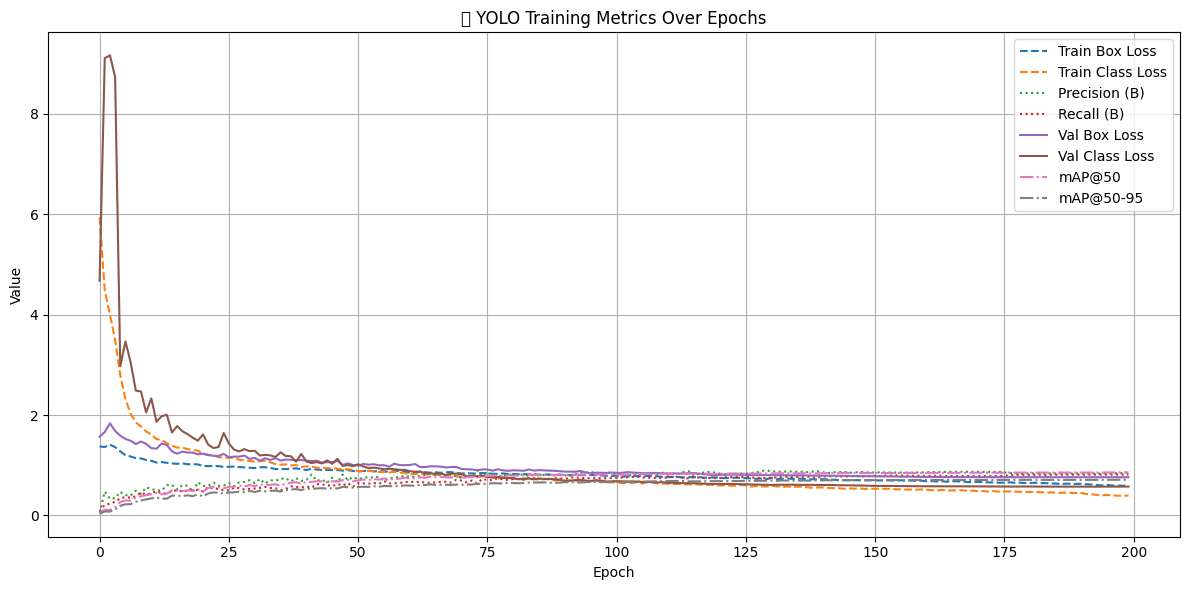

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# === STEP 1: Load the results.csv ===
# Replace with your path to YOLO training logs
csv_path = '/content/runs/detect/train/results.csv'  # or 'runs/train/yolo12n_final_tuned/results.csv'
df = pd.read_csv(csv_path)

# === STEP 2: Plot Loss Curves ===
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['train/box_loss'], label='Train Box Loss', linestyle='--')
plt.plot(df.index, df['train/cls_loss'], label='Train Class Loss', linestyle='--')
plt.plot(df.index, df['metrics/precision(B)'], label='Precision (B)', linestyle=':')
plt.plot(df.index, df['metrics/recall(B)'], label='Recall (B)', linestyle=':')
plt.plot(df.index, df['val/box_loss'], label='Val Box Loss')
plt.plot(df.index, df['val/cls_loss'], label='Val Class Loss')
plt.plot(df.index, df['metrics/mAP50(B)'], label='mAP@50', linestyle='-.')
plt.plot(df.index, df['metrics/mAP50-95(B)'], label='mAP@50-95', linestyle='-.')

plt.title("📊 YOLO Training Metrics Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
from ultralytics import YOLO

# Load your pretrained YOLOv12n model
model = YOLO('/content/runs/detect/train/weights/best.pt')
model.model.eval()

# === BNSF Pruning Function ===
def bnsf_prune_model(model, prune_ratio=0.3):
    for name, module in model.model.named_modules():
        if isinstance(module, nn.BatchNorm2d):
            # Get absolute γ values
            gamma = module.weight.data.abs().clone()
            num_channels = gamma.shape[0]
            num_prune = int(num_channels * prune_ratio)

            if num_prune < 1:
                continue

            # Identify channels to prune
            prune_idx = torch.argsort(gamma)[:num_prune]
            mask = torch.ones_like(gamma)
            mask[prune_idx] = 0  # Mark for pruning

            # Apply the pruning mask (zero out γ)
            module.weight.data.mul_(mask)
            module.bias.data.mul_(mask)

    return model

# === Apply BNSF Pruning ===
bnsf_model = bnsf_prune_model(model, prune_ratio=0.3)
torch.save(bnsf_model.model.state_dict(), 'yolo12n_pruned_bnsf.pt')


In [ ]:
import torch
from ultralytics import YOLO
from thop import profile

# === Load YOLO model config ===
model = YOLO('yolo12n.yaml')  # Use your model config
model.model.load_state_dict(torch.load('yolo12n_pruned_bnsf.pt'))  # Load pruned weights
model.model.eval()

# === Validation (mAP, etc.) ===
results = model.val(
    data='/content/Road-sign-detection-1/data.yaml',
    imgsz=640
)

print("\n📊 Validation Metrics:")
print(f"mAP@0.5: {results.box.map50:.3f}")
print(f"mAP@0.5:0.95: {results.box.map:.3f}")

# === FLOPs and Parameters ===
dummy_input = torch.randn(1, 3, 640, 640)
flops, params = profile(model.model, inputs=(dummy_input,), verbose=False)

print(f"\n📉 FLOPs       : {flops / 1e9:.2f} GFLOPs")
print(f"📦 Parameters  : {params / 1e6:.2f} Million")